# Selección de características

El primer paso es la importación de las librerias necesarias en el análisis.

In [1]:
import pandas as pd
import numpy as np
import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

Se ha realizado una preselección de todas las variables almacenadas en la base de datos de Cassandra. Esta base de datos contiene 4229 variables distintas que guardan datos de toda la planta. Para realizar un modelo del proceso de descarga no se necesitan todas esas variables, ya que la mayoría no afecta de ninguna manera al proceso. A través de un método manual, se preseleccionaron las variables o características que se intuyen más relevantes en el problema y se guardaron en un excel ('Preseleccion_variables.xlsx).

Los datos de las variables preseleccionadas se agregaron en valores promediados cada minuto para homogeneizarlos, ya que no todas las señales están guardadas con el mismo paso de tiempo, y también para reducir el tamaño del dataset. Un minuto se considera un tiempo relevante para poder apreciar cambios en las variables. Esta agregación se realizó con una aplicación SPARK que almacenó los resultados en otra tabla de Cassandra denominada 'spark_agregados_descarga_shagaya'. Posteriormente, con el script de python 'consulta_datos_tfm.py' se descargaron los datos y formatearon para agrupar los datos por columnas. El resultado se guardo en un fichero pickle para su lectura rápida desde python 'Datos_descarga_2023-04-21_162451.pickle'.

## Carga de datos

Se cargan los datos desde el fichero pickle en un dataframe y se determina su tamaño

In [2]:
datos = pd.read_pickle('Datos_descarga_2023-04-21_162451.pickle')
datos.shape

(1037976, 29)

Se observan las primeras filas de datos para ver la estructura del dataframe

In [3]:
datos.head(5)

,11CXA01GZ001XK05_A.PV_Out#Value,11CXA01GZ001XK06_A.PV_Out#Value,11CXA01GZ001XK07_A.PV_Out#Value,11CXA01GZ001XK08_A.PV_Out#Value,11CXA01GZ001XK09_A.PV_Out#Value,11CXA02GZ001XK05_A.PV_Out#Value,11CXA02GZ001XK06_A.PV_Out#Value,11CXA02GZ001XK07_A.PV_Out#Value,11CXA02GZ001XK08_A.PV_Out#Value,11CXA02GZ001XK09_A.PV_Out#Value,...,13WSH10CL001JT2X_X.PV_Out#Value,13WSH_MEDIA_M0.PV_Out#Value,13WSX10CT001JT3X_X.PV_Out#Value,13WSX40CF001JT01_A.PV_Out#Value,13WSX40CT001JT3X_X.PV_Out#Value,14MAY30DS901XU85_A.PV_Out#Value,15HAD13CP001JT2X_X.PV_Out#Value,15HAD13CP002JT2X_X.PV_Out#Value,15PAB20CF001JT01_A.PV_Out#Value,SUBESTACION_Potencia_Activa
time,,,,,,,,,,,,,,,,,,,,,
2017-01-06 10:06:00,9.528000,72.378998,1008.263306,3.759000,193.250320,9.597667,71.691994,1007.799988,3.103667,282.753998,...,910.834961,357.966309,279.575195,0.485388,306.874451,13.060047,NaN,NaN,NaN,10.773858
2017-01-06 10:07:00,9.589000,72.270996,1008.299988,3.399000,179.309326,9.680667,71.525002,1007.799988,3.556333,291.604980,...,910.781189,357.955353,279.562164,0.490693,306.847870,13.417258,NaN,NaN,NaN,11.170548
2017-01-06 10:08:00,9.703000,72.319328,1008.299988,3.600667,193.682327,9.726999,71.370995,1007.799988,3.105667,288.524323,...,910.461914,357.947723,279.567047,0.488040,306.825073,13.682431,NaN,NaN,NaN,11.391961
2017-01-06 10:09:00,9.793667,72.033669,1008.299988,3.579333,202.294662,9.828667,71.243332,1007.799988,3.397333,288.294983,...,910.898438,357.942261,279.564331,0.488040,306.794678,13.854372,NaN,NaN,NaN,11.553947
2017-01-06 10:10:00,9.860666,71.591995,1008.299988,4.252666,190.726334,9.888000,71.144997,1007.799988,2.766333,284.273987,...,910.118713,357.943207,279.588196,0.485388,306.751282,14.204952,NaN,NaN,NaN,11.918776


Lo primero que se observa es que los nombres de las variables no son muy intuitios, ya que se trata de los nombres únicos que provienen de Cassandra. Para mejorar la compresión, se cambian los nombres por los almacenados en el excel que se utilizo para la preselección de variables.

In [4]:
variables = pd.read_excel('Preseleccion_variables.xlsx')
variables.head()

,KKS,Nr.,KKS Cassandra,Nombre,Name,System,Units
0,NaN,1,11CXA01GZ001XK05_A.PV_Out#Value,temp_amb_1,AMBIENT TEMPERATURE 1,Weather Stations,°C
1,NaN,2,11CXA02GZ001XK05_A.PV_Out#Value,temp_amb_2,AMBIENT TEMPERATURE 2,Weather Stations,°C
2,NaN,3,11CXA01GZ001XK07_A.PV_Out#Value,pres_amb_1,AMBIENT PRESSURE 1,Weather Stations,bar
3,NaN,4,11CXA02GZ001XK07_A.PV_Out#Value,pres_amb_2,AMBIENT PRESSURE 2,Weather Stations,bar
4,NaN,5,11CXA01GZ001XK06_A.PV_Out#Value,hum_rel_1,RELATIVE HUMIDITY 1,Weather Stations,-


In [5]:
dic_nombres = dict(zip(variables['KKS Cassandra'], variables.Nombre)) # Creo un diccionario con los kks y sus nombres de variable
datos.rename(columns=dic_nombres, inplace=True) # Renombro las columnas del dataframe de datos

In [6]:
datos.head(5)

,temp_amb_1,hum_rel_1,pres_amb_1,vel_viento_1,dir_viento_1,temp_amb_2,hum_rel_2,pres_amb_2,vel_viento_2,dir_viento_2,...,nivel_tanque_caliente,temp_tanque_caliente,temp_sal_fria,flujo_vol_sal_caliente,temp_sal_caliente,pot_bruta,pres_cald_1,pres_cald_2,flujo_agua_circulacion,pot_neta
time,,,,,,,,,,,,,,,,,,,,,
2017-01-06 10:06:00,9.528000,72.378998,1008.263306,3.759000,193.250320,9.597667,71.691994,1007.799988,3.103667,282.753998,...,910.834961,357.966309,279.575195,0.485388,306.874451,13.060047,NaN,NaN,NaN,10.773858
2017-01-06 10:07:00,9.589000,72.270996,1008.299988,3.399000,179.309326,9.680667,71.525002,1007.799988,3.556333,291.604980,...,910.781189,357.955353,279.562164,0.490693,306.847870,13.417258,NaN,NaN,NaN,11.170548
2017-01-06 10:08:00,9.703000,72.319328,1008.299988,3.600667,193.682327,9.726999,71.370995,1007.799988,3.105667,288.524323,...,910.461914,357.947723,279.567047,0.488040,306.825073,13.682431,NaN,NaN,NaN,11.391961
2017-01-06 10:09:00,9.793667,72.033669,1008.299988,3.579333,202.294662,9.828667,71.243332,1007.799988,3.397333,288.294983,...,910.898438,357.942261,279.564331,0.488040,306.794678,13.854372,NaN,NaN,NaN,11.553947
2017-01-06 10:10:00,9.860666,71.591995,1008.299988,4.252666,190.726334,9.888000,71.144997,1007.799988,2.766333,284.273987,...,910.118713,357.943207,279.588196,0.485388,306.751282,14.204952,NaN,NaN,NaN,11.918776


## Datos faltantes

Con ayuda de la libería missingno, se puede ver gráficamente que periodos de datos faltan para cada una de las variables

<AxesSubplot: >

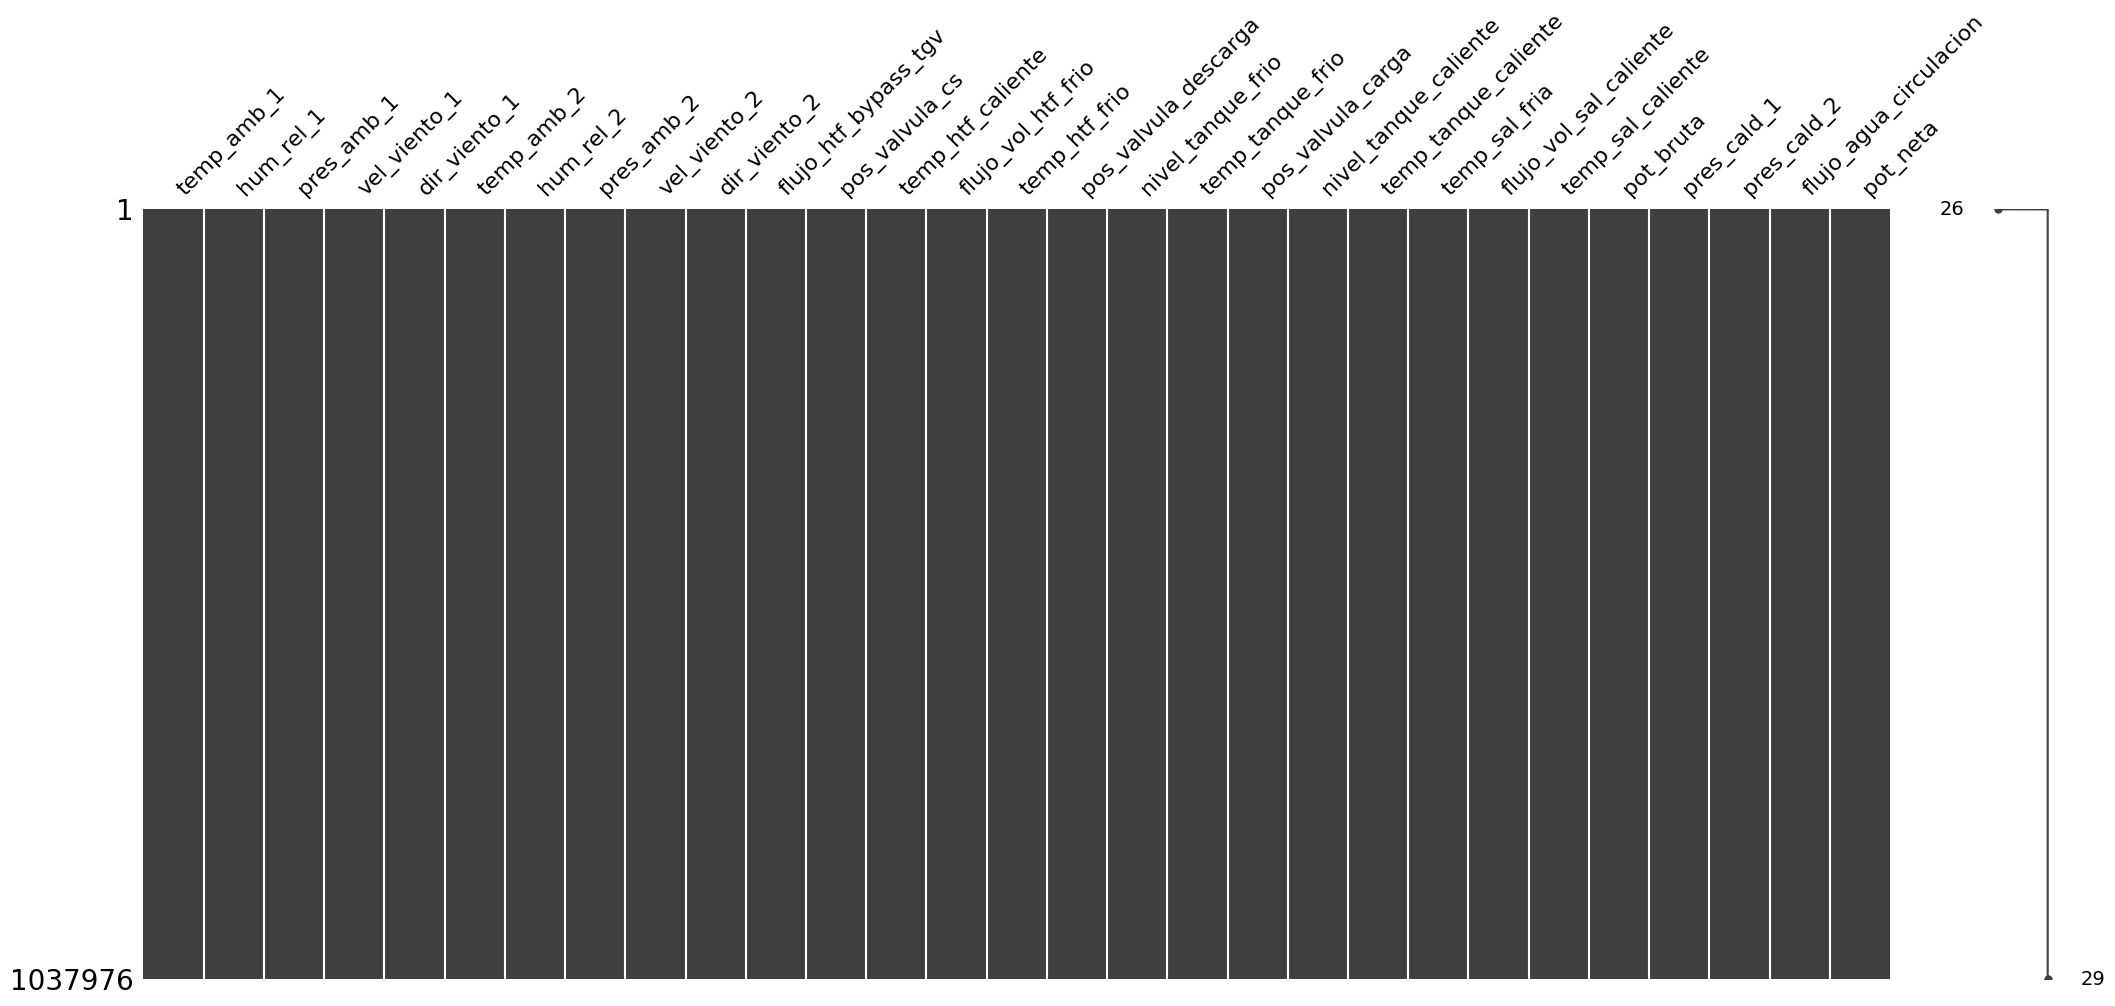

In [7]:
msno.matrix(datos)

En el gráfico anterior se puede apreciar que practicamente no hay datos faltantes. Con el mini gráfico indicador de la derecha, se puede apreciar que existen algunos registros al principio que tienen datos de 26 variables, en vez de con 29, por lo que hay registros en los que faltan 3 variables. Para ver qué variables en concreto faltan y cuántos registros, se suman los valores faltantes por columna.

In [8]:
datos.isna().sum()

temp_amb_1                  0
hum_rel_1                   0
pres_amb_1                  0
vel_viento_1                0
dir_viento_1                0
temp_amb_2                  0
hum_rel_2                   0
pres_amb_2                  0
vel_viento_2                0
dir_viento_2                0
flujo_htf_bypass_tgv        0
pos_valvula_cs              0
temp_htf_caliente           0
flujo_vol_htf_frio          0
temp_htf_frio               0
pos_valvula_descarga        0
nivel_tanque_frio           0
temp_tanque_frio            0
pos_valvula_carga           0
nivel_tanque_caliente       0
temp_tanque_caliente        0
temp_sal_fria               0
flujo_vol_sal_caliente      0
temp_sal_caliente           0
pot_bruta                   0
pres_cald_1               599
pres_cald_2               599
flujo_agua_circulacion    599
pot_neta                    0
dtype: int64

Solo hay 599 datos faltantes en tres variables, lo que implica el 0,06% de los registros. Al ser tan pocos registros, se decide eliminarlos completamente, ya que no van a impactar significativamente en los modelos.

In [9]:
datos_sin_na = datos.dropna()
filas_borradas = len(datos.index) - len(datos_sin_na.index)
ratio_filas_borradas = filas_borradas/len(datos.index)*100
print(f"Registros eliminados: {filas_borradas} ({ratio_filas_borradas:.2f}%)")

Registros eliminados: 599 (0.06%)


## Representación de un día

A continuación, se representa un día cualquiera para ver como se comportan algunas variables relevantes

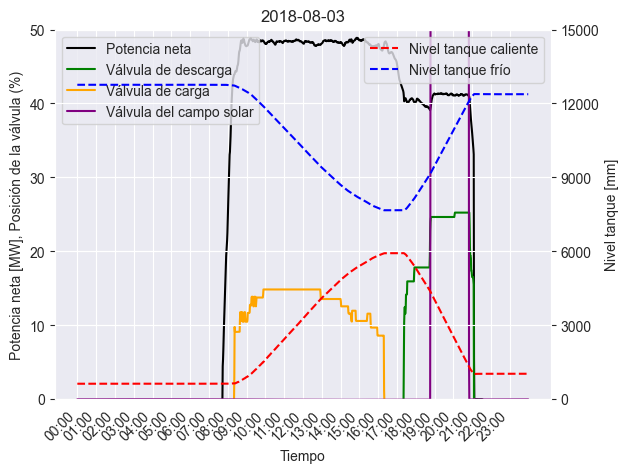

In [10]:
dia = '2018-08-03' # día a representar
datos_dia = datos_sin_na.loc[dia]

# Configuración de la gráfica
sns.set_style('darkgrid')
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Líneas a representar
sns.lineplot(data=datos_dia.pot_neta, ax=ax1, color = 'black', label='Potencia neta')
sns.lineplot(data=datos_dia.pos_valvula_descarga, ax=ax1, color='green', label = 'Válvula de descarga')
sns.lineplot(data=datos_dia.pos_valvula_carga, ax=ax1, color='orange', label = 'Válvula de carga')
sns.lineplot(data=datos_dia.pos_valvula_cs, ax=ax1, color='purple', label = 'Válvula del campo solar')
sns.lineplot(data=datos_dia.nivel_tanque_caliente, ax=ax2, color='red', label = 'Nivel tanque caliente')
sns.lineplot(data=datos_dia.nivel_tanque_frio, ax=ax2, color='blue', label = 'Nivel tanque frío')
ax2.lines[0].set_linestyle("--")
ax2.lines[1].set_linestyle("--")

# Configuración de los ejes
ax1.set_ylabel('Potencia neta [MW], Posición de la válvula (%)')
ax1.set_ylim(0,50)
ax1.set_yticks([0,10,20,30,40,50])
ax2.set_ylabel('Nivel tanque [mm]')
ax2.set_ylim(0,15000)
ax2.set_yticks([0,3000,6000,9000,12000,15000])
ax1.set_xlabel('Tiempo')
ax1.set_title(dia)
ax1.set_xticks(datos_dia.index[datos_dia.index.minute == 0], datos_dia.index[datos_dia.index.minute == 0].strftime('%H:%M'))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")

# Posición de las leyendas
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

En el gráfico del día anterior se aprecia el comportamiento habitual de un día soleado. A las 9:00 de la mañana sale el sol y se empieza a producir electricidad, y por tanto la potencia neta empieza aumentar hasta aproximadamente 50 MW. Esta potencia se mantiene hasta las 15:00 que empieza a bajar debido a que empieza a anochecer y durante alrededor de una hora se produce el transitorio entre día y noche, con una potencia un poco superior a 40MW, para volver luego a cerca de 50 MW durante la descarga que continua todavía al final del día. El comportamiento del sistema de almacenamiento se puede apreciar con los niveles de los tanques. Mientra hubo sol, se aprecia como el nivel de sales frías desciende mientras que el caliente aumenta. Las sales están siendo bombeadas de un tanque a otro, calentandose en el proceso. Cuando se pone el sol, empieza la descarga y se ve el comportamiento contrario. El nivel del tanque caliente baja mientras que el frío sube. También se representa la posición de las válvulas de carga, descarga y del campo solar, que permiten identificar el modo de funcionamiento de la planta.

## Filtrado datos de la descarga


Como el modelo va a predecir solo el comportamiento durante la descarga, se procede a filtrar los datos para que el dataset solo contenga datos de este modo de operación. El filtrado se hace con la ayuda de la señal de la válvula de descarga y de la válvula del campo solar. También se elimina la variable de la válvula de carga que estará siempre cerrada en este modo de funcionamiento.

In [11]:
datos_descarga = datos_sin_na[(datos_sin_na.pos_valvula_descarga > 10) & (datos_sin_na.pos_valvula_cs > 10)].drop('pos_valvula_carga', axis=1)
porcentaje_descarga = len(datos_descarga.index) / len(datos_sin_na.index)*100
print(f"Porcentaje de tiempo en modo descarga: {porcentaje_descarga:.1f}%")
datos_descarga.shape

Porcentaje de tiempo en modo descarga: 11.9%


(123491, 28)

In [12]:
pd.set_option('display.max_columns', None)
datos_descarga.describe()

,temp_amb_1,hum_rel_1,pres_amb_1,vel_viento_1,dir_viento_1,temp_amb_2,hum_rel_2,pres_amb_2,vel_viento_2,dir_viento_2,flujo_htf_bypass_tgv,pos_valvula_cs,temp_htf_caliente,flujo_vol_htf_frio,temp_htf_frio,pos_valvula_descarga,nivel_tanque_frio,temp_tanque_frio,nivel_tanque_caliente,temp_tanque_caliente,temp_sal_fria,flujo_vol_sal_caliente,temp_sal_caliente,pot_bruta,pres_cald_1,pres_cald_2,flujo_agua_circulacion,pot_neta
count,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000,123491.000000
mean,21.929734,49.928167,996.999136,1.880415,140.039750,21.568127,52.270198,996.688504,1.689943,112.995560,2526.711896,98.973707,373.644799,1864.483625,278.252998,20.503610,8013.406762,286.227735,5551.267164,383.662975,284.846266,1373.280798,380.455095,37.511544,73.438992,73.255344,9382.544175,33.873585
std,6.006710,16.093284,3.392563,1.381605,126.158850,5.566236,15.889354,3.393887,1.291399,106.642339,408.936881,8.217777,13.565602,487.856618,6.276665,11.964252,2831.055031,4.980427,2937.460397,4.435150,7.615404,361.075965,16.671043,8.950783,17.291412,17.252838,1299.417429,8.288581
min,-22.431999,0.313667,984.400024,0.000000,-327.386322,4.473000,10.894667,984.100037,0.000000,-327.490997,-1.050332,10.001687,275.850677,-0.403646,253.203125,10.463325,1182.526367,276.273499,628.299561,353.810516,242.005203,0.469473,262.837433,0.012665,0.245587,0.255546,73.965561,-2.833792
25%,18.528000,37.668333,994.726685,0.895333,53.808666,18.137833,40.001999,994.580017,0.748000,58.849333,2484.522095,99.887993,373.646774,1560.312500,273.639450,15.719522,5921.571045,281.848557,3035.298340,381.869614,280.600037,1158.672241,381.161560,32.960217,64.413353,64.251572,9525.951172,29.645491
50%,21.964333,50.112667,996.600037,1.730333,140.985001,21.579666,52.679665,996.223328,1.528667,104.909996,2599.539551,99.892342,375.789917,1683.710815,276.496033,17.192564,8367.220703,285.580902,5183.539551,384.521210,284.842651,1242.441406,383.704407,35.974857,70.239677,70.052071,9572.337891,32.577229
75%,26.000000,61.745499,998.799988,2.745000,258.387665,25.495998,64.010498,998.400024,2.472000,182.984322,2692.084717,99.898605,377.817902,2365.429688,284.272583,22.747637,10436.522461,290.780731,7719.080322,386.607880,290.538177,1735.131226,385.401459,45.605263,89.388790,89.168480,9620.514648,41.294430
max,41.813999,92.654663,1014.400024,10.102333,327.582001,42.625000,93.955002,1014.200012,13.817333,327.146332,4018.694092,99.915848,385.634491,2693.728271,306.269257,99.391876,12751.979492,299.550110,12624.773438,391.727478,310.653198,1883.948975,389.018005,52.776703,102.428345,102.166039,10669.469727,48.374264


Viendo los valores que toman las variables, se puede deducir que todavía hay registros en el dataset en los que no se están descargando las sales, ya que por ejemplo hay valores con flujo de sales 0. Esto se debe a que puede haber momentos con la válvula abierta pero la bomba todavía no se arrancó. Por lo tanto, se eliminan los registros con flujos menores de 200 m3/h.

También se eliminan los registros con una potencia neta menor de 10 MW, ya que una potencia tan baja solo ocurre durante algunos transitorios y no es representativa.

In [13]:
datos_descarga.drop(datos_descarga[datos_descarga.flujo_vol_sal_caliente < 200].index, inplace=True)
datos_descarga.drop(datos_descarga[datos_descarga.pot_neta < 10].index, inplace=True)
datos_descarga.describe()

,temp_amb_1,hum_rel_1,pres_amb_1,vel_viento_1,dir_viento_1,temp_amb_2,hum_rel_2,pres_amb_2,vel_viento_2,dir_viento_2,flujo_htf_bypass_tgv,pos_valvula_cs,temp_htf_caliente,flujo_vol_htf_frio,temp_htf_frio,pos_valvula_descarga,nivel_tanque_frio,temp_tanque_frio,nivel_tanque_caliente,temp_tanque_caliente,temp_sal_fria,flujo_vol_sal_caliente,temp_sal_caliente,pot_bruta,pres_cald_1,pres_cald_2,flujo_agua_circulacion,pot_neta
count,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000,120948.000000
mean,22.055737,49.928845,996.913580,1.882054,139.940689,21.681463,52.329442,996.604023,1.691165,111.010151,2579.511401,98.954869,375.524791,1903.426512,278.696701,18.863838,8034.542452,286.168270,5525.806311,383.718973,285.589373,1401.440956,382.769814,38.298794,74.968974,74.781199,9568.214078,34.585722
std,5.956716,16.007598,3.366705,1.383687,127.042080,5.517123,15.799388,3.369569,1.295908,105.930812,186.913689,8.301247,3.833306,411.074477,5.522541,3.750171,2856.401624,5.012530,2962.347090,4.459938,5.626195,307.134732,4.167813,7.188846,13.827257,13.800270,89.580729,6.745200
min,-22.431999,0.313667,984.400024,0.000000,-327.386322,4.473000,10.894667,984.100037,0.000000,-327.490997,-0.519488,10.001687,343.776306,35.156250,261.493866,10.463325,1182.526367,276.273499,634.803650,353.812866,272.479370,507.978180,353.896454,13.721421,38.869396,38.763988,9086.697266,10.872054
25%,18.668834,37.776250,994.700012,0.895333,52.709579,18.246666,40.139584,994.520020,0.742333,58.400080,2492.177612,99.887993,373.838959,1574.628906,273.747284,15.712649,5857.121826,281.795807,2995.058960,382.035622,280.826813,1167.489471,381.329193,33.109676,64.866106,64.703310,9529.169922,29.821510
50%,22.073999,50.089998,996.500000,1.731000,140.621490,21.656666,52.685997,996.200012,1.528667,102.734665,2603.019897,99.892342,375.866150,1696.030762,276.652832,17.184727,8457.750000,285.344421,5089.614014,384.617203,285.109314,1250.000000,383.872864,36.113544,70.473206,70.286354,9574.127930,32.684513
75%,26.088750,61.689166,998.600037,2.745333,260.513824,25.586417,64.036749,998.400024,2.473000,175.587662,2694.373413,99.898605,377.870270,2370.222412,284.334908,22.654200,10473.363281,290.838440,7786.415527,386.653534,290.567474,1736.131226,385.441620,45.650852,89.506540,89.289099,9621.640381,41.346386
max,41.813999,92.654663,1014.400024,10.102333,327.582001,42.625000,93.955002,1014.200012,13.817333,327.146332,4018.694092,99.915848,385.634491,2693.728271,306.269257,27.510729,12728.295898,299.550110,12624.773438,391.727478,310.653198,1883.948975,389.018005,52.776703,102.428345,102.166039,9849.102539,48.374264


## Creación de columnas transformadas

En el dataset existen varias variables repetidas, mediciones provenientes de distintos sensores pero que miden lo mismo. Este el caso de las variables meteorológicas, que para cada una de ellas, se disponen las medidas de las 2 estaciones meteorológicas existentes en la planta. Como se desconoce qué sensores son más fiables o tienen menos error, se hace un promedio de las dos medidas.

In [14]:
datos_descarga['temp_amb'] = (datos_descarga.temp_amb_1 + datos_descarga.temp_amb_2)/2
datos_descarga['hum_rel'] = (datos_descarga.hum_rel_1 + datos_descarga.hum_rel_2)/2
datos_descarga['vel_viento'] = (datos_descarga.vel_viento_1 + datos_descarga.vel_viento_2)/2
datos_descarga['dir_viento'] = (datos_descarga.dir_viento_1 + datos_descarga.dir_viento_2)/2
datos_descarga['pres_amb'] = (datos_descarga.pres_amb_1 + datos_descarga.pres_amb_2)/2

datos_descarga.drop(['temp_amb_1', 'temp_amb_2', 'hum_rel_1', 'hum_rel_2', 'vel_viento_1', 'vel_viento_2', 'dir_viento_1', 'dir_viento_2', 'pres_amb_1', 'pres_amb_2'], axis=1, inplace=True)

Una vez filtrados los datos, hay que crear una columna transformada que indique la eficiencia de la descarga, que será la variable a predecir por el modelo. La eficiencia de la descarga se define como la potencia eléctrica generada dividida por la potencia térmica extraida de las sales fundidas. 

La potencia térmica extraida de las sales se calcula como el flujo másico de sales por la diferencia de entalpías entre la sal caliente y la sal fría. 

Por último, tanto la entalpía como la densidad de las sales se calculan con formulas obtenidas empíricamente a partir de la temperatura.

In [15]:
def flujo_mas_sal (flujo_vol_sal, temp):
    # Función que cálcula el flujo másico de las sales fundidas, en kg/s, a partir de su flujo volumétrico en m3/h y su temperatura en ºC
    rho0 = 2090
    rho1 = -0.636
    densidad_sal = rho0 + rho1 * temp
    flujo_mas_sal = flujo_vol_sal * densidad_sal / 3600
    return flujo_mas_sal

def entalpia_sal (T):
    # Calculo de la entalpía de la sal en función de su temperatura en grados centígrados
    # Devuelve la entalía en kJ/kg
    h1 = 1.4475 
    h2 = 8.5915e-5 
    h = h1*T + h2 ** 2
    return h

datos_descarga['flujo_mas_sal'] = datos_descarga.apply(lambda f: flujo_mas_sal(f.flujo_vol_sal_caliente, f.temp_sal_caliente), axis=1)
datos_descarga['pot_termica_descarga'] = datos_descarga.apply(lambda f: 
(f.flujo_mas_sal # Flujo de sal, en kg/s
* (entalpia_sal(f.temp_sal_caliente) - entalpia_sal(f.temp_sal_fria))) # Se multiplica por la diferencia de entalpías, en kJ/kg
/1000, # Se divide entre 1000 para convertir a MW
axis=1)

In [16]:
datos_descarga['eficiencia_descarga'] = datos_descarga.pot_neta / datos_descarga.pot_termica_descarga

Otra de las columnas transformadas que se crean es el ratio entre el flujo másico de sal y de HTF, que es un parámetro que utilizan los operadores durante la descarga para controlar el proceso. Para calcular este ratio, hay que primero convertir el flujo volumétrico de HTF a flujo másico. 

In [17]:
def flujo_mas_htf (flujo_vol_htf, temp):
    # Función que cálcula el flujo másico de HTF, en kg/s, a partir de su flujo volumétrico en m3/h y su temperatura en ºC
    rho0 = 1076.9
    rho1 = -0.83812
    rho2 = 0.00029881
    rho3 = -0.0000016914
    densidad_htf = rho0 + rho1 * temp + rho2 * temp ** 2 + rho3 * temp ** 3
    flujo_mas_htf = flujo_vol_htf * densidad_htf / 3600
    return flujo_mas_htf

# El flujo volumétrico de htf se mide en el lado frío
datos_descarga['ratio_flujo_mas_sal_htf'] = datos_descarga.flujo_mas_sal / flujo_mas_htf(datos_descarga.flujo_vol_htf_frio, datos_descarga.temp_htf_frio)

In [18]:
datos_descarga.loc[:,['pot_termica_descarga','eficiencia_descarga']].describe()

,pot_termica_descarga,eficiencia_descarga
count,120948.000000,120948.000000
mean,99.656800,0.346219
std,16.206823,0.033333
min,36.127959,0.164121
25%,88.304705,0.332953
50%,95.738221,0.344328
75%,117.030529,0.353852
max,131.301553,1.184913


## Eliminación de outliers

Es físicamente imposible obtener una eficiencia de descarga por encima del 100% o incluso por encima del 50%, aunque según los resultados obtenidos hay registros con eficiencias de hasta el 118%. Se trata de registros atípicos que hay que eliminar del análisis para que no afecten negativamente al rendimiento del modelo. 

In [19]:
datos_descarga.drop(datos_descarga[datos_descarga.eficiencia_descarga > 0.5 ].index, inplace=True)

Para ver si existen más outliers en la eficiencia, se representa el histograma

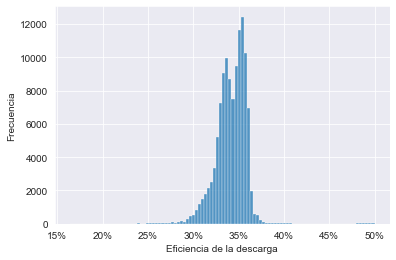

In [20]:
sns.histplot(data=datos_descarga, x='eficiencia_descarga', bins=100)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.ylabel('Frecuencia')
plt.xlabel('Eficiencia de la descarga')
plt.show()

Se observa que la gran mayoría de valores se agrupan entre aproximadamente el 28% y el 37%. Los valores fuera de ese rango se consideran outliers y se eliminan.

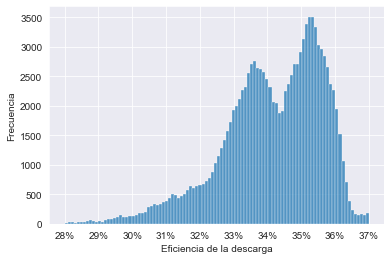

In [21]:
datos_descarga.drop(datos_descarga[(datos_descarga.eficiencia_descarga > 0.37) |  (datos_descarga.eficiencia_descarga < 0.28)].index, inplace=True)
sns.histplot(data=datos_descarga, x='eficiencia_descarga', bins=100)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.ylabel('Frecuencia')
plt.xlabel('Eficiencia de la descarga')
plt.xticks(np.arange(0.28, 0.38, 0.01))
plt.show()

Se puede ver que hay dos comportamientos distintos. Esto se debe a que la planta estuvo trabajando en 2 situaciones distintas a lo largo del tiempo. El primer pico, alrededor del 33,5% de eficiencia se obtiene cuando se operaba a menos potencia. El segundo pico, de más del 35%, se da cuando se trabaja a la potencia alta. Esto se puede corrobar ya que el histograma de la potencia neta, en el que también se aprecian dos picos diferenciados.

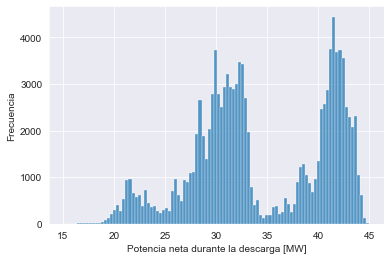

In [26]:
sns.histplot(data=datos_descarga, x='pot_neta', bins=100)
plt.ylabel('Frecuencia')
plt.xlabel('Potencia neta durante la descarga [MW]')
plt.show()

<AxesSubplot:>

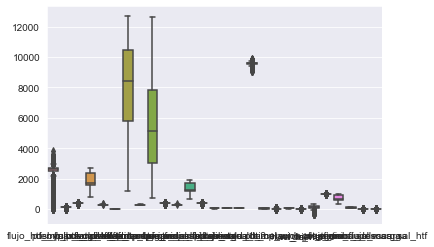

In [22]:
sns.boxplot(data=datos_descarga)

Para detectar otros outliers, se hacen gráficos de caja de las variables. Como tienen unidades distintas se separan en bloques para poder verlos mejor

In [23]:
datos_descarga.columns

Index(['flujo_htf_bypass_tgv', 'pos_valvula_cs', 'temp_htf_caliente',
       'flujo_vol_htf_frio', 'temp_htf_frio', 'pos_valvula_descarga',
       'nivel_tanque_frio', 'temp_tanque_frio', 'nivel_tanque_caliente',
       'temp_tanque_caliente', 'temp_sal_fria', 'flujo_vol_sal_caliente',
       'temp_sal_caliente', 'pot_bruta', 'pres_cald_1', 'pres_cald_2',
       'flujo_agua_circulacion', 'pot_neta', 'temp_amb', 'hum_rel',
       'vel_viento', 'dir_viento', 'pres_amb', 'flujo_mas_sal',
       'pot_termica_descarga', 'eficiencia_descarga',
       'ratio_flujo_mas_sal_htf'],
      dtype='object')

<AxesSubplot:>

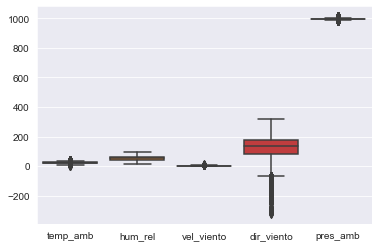

In [24]:
# Variables meteorológicas
sns.boxplot(data=datos_descarga.loc[:,['temp_amb', 'hum_rel', 'vel_viento', 'dir_viento', 'pres_amb']])

No se ven outliers claros en estas variables, así que se mantienen todos los datos.

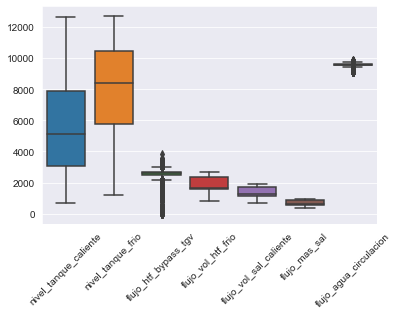

In [25]:
# Niveles de los tanques y flujos de HTF, sales y agua de circulación
ax = sns.boxplot(data=datos_descarga.loc[:,['nivel_tanque_caliente','nivel_tanque_frio', 'flujo_htf_bypass_tgv', 'flujo_vol_htf_frio', 'flujo_vol_sal_caliente', 'flujo_mas_sal','flujo_agua_circulacion']])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

Se decide mantener todos los registros, ya que aunque se encuentren valores fuera del bigote, se deben a circunstancias normales de operación.

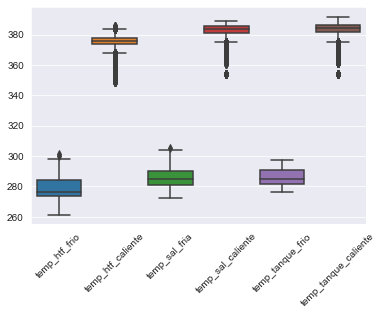

In [27]:
# Temperaturas
ax = sns.boxplot(data=datos_descarga.loc[:,['temp_htf_frio','temp_htf_caliente', 'temp_sal_fria', 'temp_sal_caliente', 'temp_tanque_frio', 'temp_tanque_caliente']])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

Se decide mantener todos los registros, ya que aunque se encuentren valores fuera del bigote, se deben a circunstancias normales de operación.

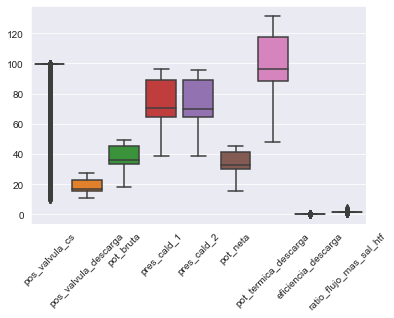

In [28]:
# Resto de variables
ax = sns.boxplot(data=datos_descarga.loc[:,['pos_valvula_cs', 'pos_valvula_descarga',
       'pot_bruta', 'pres_cald_1', 'pres_cald_2', 'pot_neta',
       'pot_termica_descarga', 'eficiencia_descarga', 'ratio_flujo_mas_sal_htf']])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

Se decide mantener todos los registros, ya que aunque se encuentren valores fuera del bigote, se deben a circunstancias normales de operación.

## Eliminación de variables de salida del proceso

El modelo de machine learning que se desarrollará va a predecir la eficiencia de descarga. Todas las variables de salida del proceso, y que no se conocen de antemano cuando se vaya a utilizar el modelo, deben de ser eliminadas. Solo las variables externas y las que pueden ser controladas por los operadores de la planta se mantienen en el dataset para alimentar a los modelos.

In [29]:
datos_descarga.drop(['pot_neta', 'pot_bruta', 'pres_cald_1', 'pres_cald_2'], axis=1, inplace=True)

## Correlación entre variables

Para determinar las variables más interesantes en el problema, se representa la matriz de correlaciones.

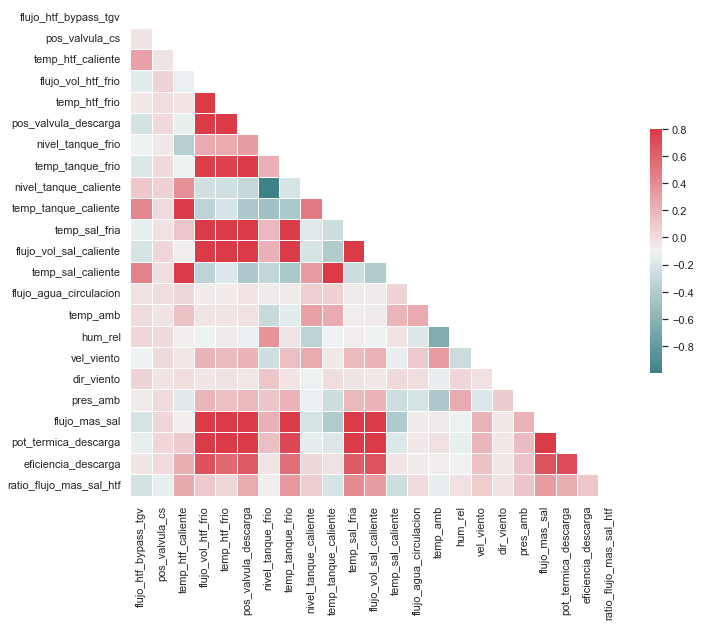

In [30]:
plt.rcParams['figure.figsize'] = [10, 5] # Tamaño de la figura

corr = datos_descarga.corr()
sns.set(style="whitegrid")
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(200, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

La matriz de correlaciones aporta información muy valiosa para el problema. Lo primero que llama la atención es que hay muchas características que tienen comportamientos muy parecidos y sus valores de correlación se parecen mucho entre sí. Para identificar las variables más correladas entre sí, se filtran los valores más altos y se listan las parejas de características más correladas.

In [31]:
corr.where(np.triu(abs(corr) > 0.9, k=1)).stack().sort_values(ascending=False)

flujo_vol_sal_caliente  flujo_mas_sal             0.999979
temp_tanque_caliente    temp_sal_caliente         0.983357
flujo_vol_htf_frio      flujo_vol_sal_caliente    0.975738
                        flujo_mas_sal             0.975248
pos_valvula_descarga    flujo_mas_sal             0.968679
                        flujo_vol_sal_caliente    0.968468
flujo_vol_sal_caliente  pot_termica_descarga      0.965659
flujo_mas_sal           pot_termica_descarga      0.964220
flujo_vol_htf_frio      pot_termica_descarga      0.959886
                        pos_valvula_descarga      0.954106
pos_valvula_descarga    pot_termica_descarga      0.922875
flujo_vol_htf_frio      temp_htf_frio             0.903333
temp_sal_fria           flujo_vol_sal_caliente    0.901172
                        flujo_mas_sal             0.900405
nivel_tanque_frio       nivel_tanque_caliente    -0.999993
dtype: float64

Las correlaciones más altas, de prácticamente el 100%, son entre los flujos de sal y entre los niveles de los tanques. Esto es lógico ya que el flujo másico se calcula a partir del flujo volumétrico de sal y por tanto están directamente relaciodos, mientras que los niveles de los tanques están negativamente correlados, ya que cuando uno sube el otro tiene que bajar en la misma proporción. 

Tambíen de manera lógica, vemos una correlación alta entre la temperatura del tanque de sales caliente y la temperatura de la sal caliente, ya que no hay ningún cambio en la sal entre ambos puntos de medida. Sin embargo, puede llamar la atención que esta relación no se aprecia entre la temperatura del tanque de sales frías y la temperatura de sal frío. Esto es debido a que la cantidad de sal fría que sale del intercambiador es muy pequeña respecto a la que permanece en el tanque, por lo que al llegar al tanque predomina la temperatura de la masa que previamente estaba en el tanque.

Otras variables muy correladas entre sí, son el flujo de sal con el flujo de HTF. Para producirse un buen intercambio de calor, ambas variables deben comportarse de manera parecida y los operadores se encargan de ello. Cuando aumentan el flujo de sales, tienen que aumentar también el flujo de HTF. Lógicamente, como el flujo de sales se controla en parte con la válvula de descarga, abriendola más o menos, ambos flujos están también correlados con la posición de esta válvula.

Para reducir la dimensionalidad del problema y con ello mejorar el rendimiento de los modelos que se aplicarán posteriormente, es conveniente eliminar algunas de las caracterísiticas que presenta el dataset. Por tanto, de los grupos de variables que se han identificado muy correladas entre sí, solo se mantendrá una de ellas que represente a todo el grupo. Para decidir cuál en concreto, se ordenan las variables en función de su valor de correlación, en valor absoluto, con la variable objetivo.

Text(0.5, 0, 'Eficiencia de la descarga')

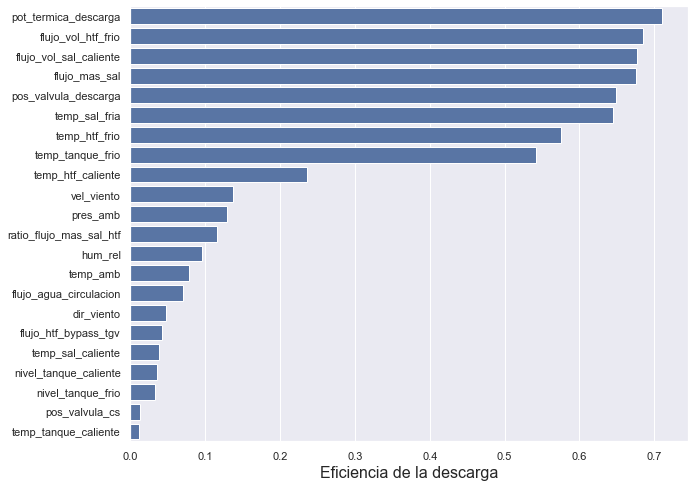

In [34]:
corr_ord = abs(corr).sort_values(by='eficiencia_descarga', axis=0, ascending=False).drop('eficiencia_descarga')

sns.set(style="darkgrid")
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_ord.eficiencia_descarga, y=corr_ord.index, color="b")
plt.xlabel("Eficiencia de la descarga", fontsize=16)

En la gráfica anterior, se observa que las mayores correlaciones se obtienen con la potencia térmica de descarga y las variables relacionadas con los flujos de HTF y sal. Las menores correlaciones, prácticamente inexistentes se obtienen con la temperatura del tanque caliente, lo cuál es un resultado muy sorprendente, ya que se esperaba que esta temperatura tuviera mucha influencia en la descarga debido a las ecuaciones termodinámicas que regulan este proceso de descarga, y con la posición de la válvula del campo solar. 

Las variables 'flujo_vol_htf_frio', 'flujo_vol_sal_caliente', 'flujo_mas_sal' y 'pos_valvula_descarga' estaban muy correladas entre sí. Se selecciona de entre todas ellas, el flujo de htf.

De entre los niveles de los tanques, se selecciona el nivel del tanque caliente.

De las temperaturas de sal caliente, se selecciona la temperatura de sal en los intercambiadores.

También se elimina la variable con la posición de la válvula del campo solar, ya que apenas afecta a la descarga. Solo se había utilizado para filtrar los momentos de la descarga.

In [35]:
variables_a_eliminar = ['flujo_vol_sal_caliente', 'flujo_mas_sal', 'pos_valvula_descarga', 'nivel_tanque_frio', 'temp_tanque_caliente', 'pos_valvula_cs']
datos_descarga.drop(variables_a_eliminar, axis=1, inplace=True)

In [36]:
datos_descarga.shape

(116185, 17)

A continuación, se representan para ver cómo se agrupan los valores de la eficiencia de la descarga en función de las dos variables más correladas con ella.

C:\Users\LUIS~1.MIL\AppData\Local\Temp/ipykernel_11252/2801107099.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sm, cax=plt.gcf().add_axes([0.92, 0.1, 0.03, 0.8]))


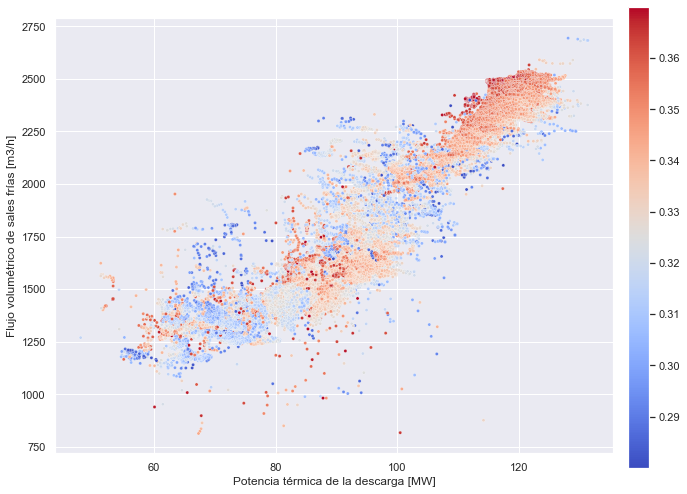

In [38]:
# Creación de un gráfico de dispersión con dos variables
sns.set(style="darkgrid")
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(x='pot_termica_descarga', y='flujo_vol_htf_frio', hue='eficiencia_descarga', data=datos_descarga, s=10, palette='coolwarm', legend='auto')

# Etiquetas de los ejes y barra de colores de la leyenda
plt.xlabel('Potencia térmica de la descarga [MW]')
plt.ylabel('Flujo volumétrico de sales frías [m3/h]')

norm = plt.Normalize(datos_descarga['eficiencia_descarga'].min(), datos_descarga['eficiencia_descarga'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])

ax.get_legend().remove()
plt.colorbar(sm, cax=plt.gcf().add_axes([0.92, 0.1, 0.03, 0.8]))

plt.show()

In [38]:
datos_descarga.columns

Index(['flujo_htf_bypass_tgv', 'temp_htf_caliente', 'flujo_vol_htf_frio',
       'temp_htf_frio', 'temp_tanque_frio', 'nivel_tanque_caliente',
       'temp_sal_fria', 'temp_sal_caliente', 'flujo_agua_circulacion',
       'temp_amb', 'hum_rel', 'vel_viento', 'dir_viento', 'pres_amb',
       'pot_termica_descarga', 'eficiencia_descarga',
       'ratio_flujo_mas_sal_htf'],
      dtype='object')

## Análisis de Componentes Principales

El análisis de componentes principales permitirá transformar el conjunto de datos en un nuevo conjunto de variables no correlacionadas y que son combinaciones lineales de las originales, con el objetivo de reducir aún más la dimensionalidad.
Antes de realizar el análisis, se normalizan los datos para igualar las escalas y que todas tengan la misma importancia relativa. Los datos originales tienen escalas muy distintas, por lo que este paso es necesario para evitar que las variables con valores más grandes dominen el análisis. Se aplica el análisis a todo el dataset sin incluir la columna de la eficiencia de descarga que queremos mantenerla, ya que es la variable a predecir.

In [39]:
# Se crea un dataset sin la columna de la eficiencia
X = datos_descarga.drop(['eficiencia_descarga'], axis=1)

scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)
print('Máximos: ', X_norm.max(axis=0))
print('Mínimos: ', X_norm.min(axis=0))

Máximos:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mínimos:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Con los datos normalizados, se prueba a reducir el dataset ya tratado, que contiene 16 características a varios componentes empleando la función PCA de sklearn.

In [40]:
# Se crea un dataset sin la columna de la eficiencia
X = datos_descarga.drop(['eficiencia_descarga'], axis=1)

for i in range(2,11):
  estimator = PCA(n_components = i)
  X_pca = estimator.fit_transform(X_norm)
  print("Varianza explicada total por ", estimator.n_components, 
      " componentes: ", f"{sum(estimator.explained_variance_ratio_):.2%}") 

Varianza explicada total por  2  componentes:  64.78%
Varianza explicada total por  3  componentes:  74.22%
Varianza explicada total por  4  componentes:  80.13%
Varianza explicada total por  5  componentes:  84.01%
Varianza explicada total por  6  componentes:  87.62%
Varianza explicada total por  7  componentes:  90.84%
Varianza explicada total por  8  componentes:  93.75%
Varianza explicada total por  9  componentes:  95.58%
Varianza explicada total por  10  componentes:  97.15%


Para mantenere un dataset que pueda explicar una gran cantidad de la variabilidad de los datos originales, se decide emplear 7 componentes, con lo que se alcanza el 90% de la varianza explicada.

In [41]:
pca = PCA(n_components=7)
comp_princ = pca.fit_transform(X_norm)

# Se crea un dataframe con las componentes principales y manteniendo el índice original
comp_princ_df = pd.DataFrame(data = comp_princ, columns = ['componente1', 'componente2', 'componente3', 'componente4', 'componente5', 'componente6', 'componente7']
                             , index=X.index)

# Se concatena con la eficiencia para crear el dataset final
final_df = pd.concat([comp_princ_df, datos_descarga['eficiencia_descarga']], axis = 1)

print("Varianza explicada por cada eje: ", pca.explained_variance_ratio_)
final_df.head()

Varianza explicada por cada eje:  [0.43904117 0.20878673 0.09436936 0.05907322 0.0387858  0.03616028
 0.03217257]


,componente1,componente2,componente3,componente4,componente5,componente6,componente7,eficiencia_descarga
time,,,,,,,,
2017-01-16 17:53:00,-0.347299,-0.217648,-0.162539,0.477760,0.311185,0.013841,0.112844,0.306006
2017-01-16 17:54:00,-0.350084,-0.227951,-0.177204,0.474238,0.361250,0.014090,0.155471,0.307990
2017-01-16 17:55:00,-0.353388,-0.218600,-0.147487,0.493382,0.293289,0.024799,0.094036,0.312124
2017-01-16 17:56:00,-0.353650,-0.215037,-0.148358,0.482319,0.328331,0.025416,0.134572,0.314885
2017-01-16 17:57:00,-0.356481,-0.217904,-0.159874,0.470682,0.384702,0.019514,0.191868,0.317008


Los componentes principales no tienen un significado claro, lo que dificulta la interpretación. Sin embargo, se representan a continuación los datos en relación con sus dos componentes principales, las cuáles explican aproximadamente el 70% de la varianza. Se representa también la eficiencia de la descarga con el color para ver si que agrupaciones de valores se han producido.

C:\Users\LUIS~1.MIL\AppData\Local\Temp/ipykernel_4388/3928268202.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sm, cax=plt.gcf().add_axes([0.92, 0.1, 0.03, 0.8]))


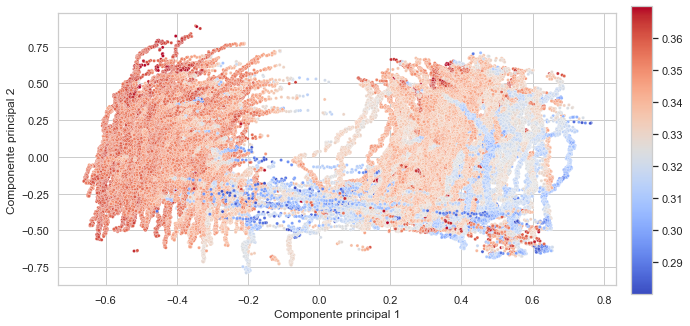

In [42]:
# Creación de un gráfico de dispersión con los dos primeros componentes principales
ax = sns.scatterplot(x='componente1', y='componente2', hue='eficiencia_descarga', data=final_df, s=10, palette='coolwarm', legend='auto')

# Etiquetas de los ejes y barra de colores de la leyenda
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')

norm = plt.Normalize(final_df['eficiencia_descarga'].min(), final_df['eficiencia_descarga'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])

ax.get_legend().remove()
plt.colorbar(sm, cax=plt.gcf().add_axes([0.92, 0.1, 0.03, 0.8]))

plt.show()

Se pueden apreciar zonas en las que predominan más las eficiencias altas, mientras que las zonas más azules en dónde se concentran las descargas con menor eficiencia.

Finalmente, se guardan los datos en un fichero pickle, que podrá ser utilizado para desarrollar los modelos

In [ ]:
nombre_pickle = 'Datos_descarga_proc_' + datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S') + '.pickle' # Nombre del fichero que incluye la hora de creación para mantener trazabilidad
final_df.to_pickle(nombre_pickle)